<br>

<div>
    <center>
        <font size = 20 color = "steelblue" > REPORT </font>
        <br>
        <br>
        <br>
        <font size = 6 color ="green"> Bayesian Optimization</font>
        <font size = 6>을 활용한 Hyperparameter Optimization
        </font>
        <br>
        <br>
        <br>
        <font size = 6> 19/04/26 이성령 </font>
        <br>
        <br>
        <br>
        <img src = "./ml_img/BayesianOptimization.jpeg"> 
    </center>

</div>

<br><br>

<div  style="text-align: right; padding-right : 50px;" >
    <font size = 6 >  </font>
</div>

# Introduction

* 기존 HyperParameter Search 방식으로는 Grid Search와 Random Search가 있다.
* 하지만 이러한 방법론들은 일정한 간격을 두고 선정을 해서 가장 좋은 결과값이 나온 parameter를 선택하거나, 임의로 랜덤으로 선택해서 찾는 방법론이다.
* 그래서 이렇게 앞에서 했던 방법과는 달리 Parameter를 사전지식으로 충분히 반영하면서 다음 좋은 Parameter를 찾도록 전체적인 탐색과정을 수행할 수 있는 방법으로 `Bayesian Optimzation`있다.
* 이번 보고서에서는 Bayesian Optimization 으로 인공신경망에 있는 Parameter를 최적화해보고자 한다.

#  Data : [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)

* `Bayesioan Optimization`  +  `NN` 을 활용해서 최적의 Hyperparameter 찾기
* 내일 비가 올 지 안올지를 예측하는 문제


# Library Load

In [1]:
import pandas as pd , numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from bayes_opt import BayesianOptimization
from sklearn.model_selection  import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import collections, os
import pickle
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.preprocessing import scale, robust_scale , normalize
from sklearn.metrics import accuracy_score
import umap
from IPython.display import display, Image
from IPython.core.display import display, HTML , clear_output
display(HTML("<style>.container { width:95% !important; }</style>"))

## 범주형 데이터는 Ohe Encoding
## 실수형 데이터는 Robust Scaling 진행
## 데이터는 7 : 3 으로 나눔

In [2]:
df = pd.read_csv("./Data/Rain/GAIN_Data.csv")

label = df["RainTomorrow"]
Input = df.drop(['Date', 'Location' , 'RainTomorrow'], axis = 1)
one_hot_category = pd.get_dummies(Input.select_dtypes("object") , drop_first = False)
numeirc_input = Input.drop(columns= Input.select_dtypes("object").columns)
numeirc_input = pd.DataFrame( robust_scale(numeirc_input.values) )
Input = pd.concat([one_hot_category , numeirc_input ] , axis = 1)
x_data = Input.values
y_data = LabelEncoder().fit_transform(label)
onehot = pd.get_dummies(label).values
x_train, x_valid, y_train, y_valid, y_train_label, y_valid_label =\
train_test_split(x_data, onehot, y_data, test_size = 0.3)

# Target의 비율

In [3]:
df.RainTomorrow.value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

# UMAP 과 T-SNE을 활용한 Data Visaulization

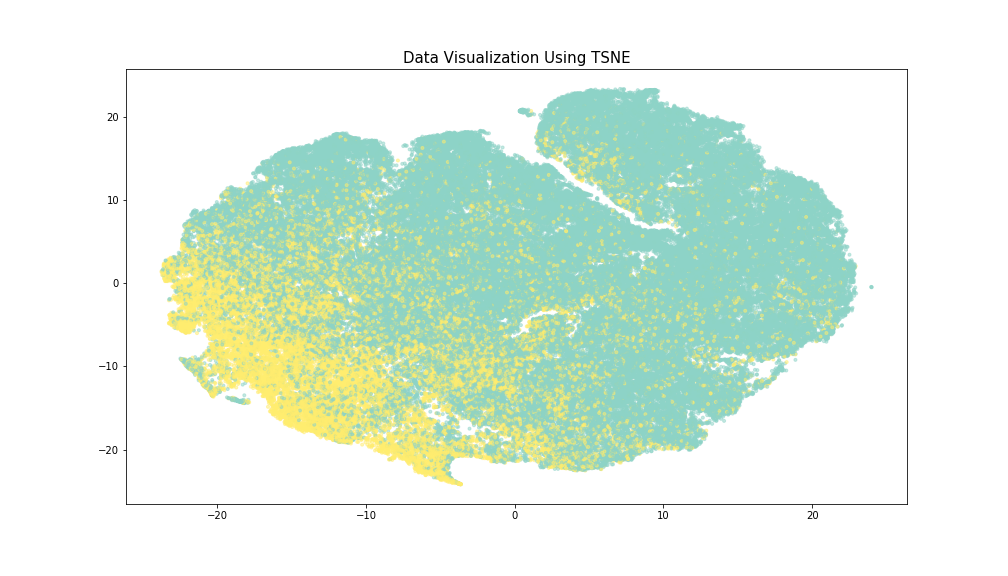

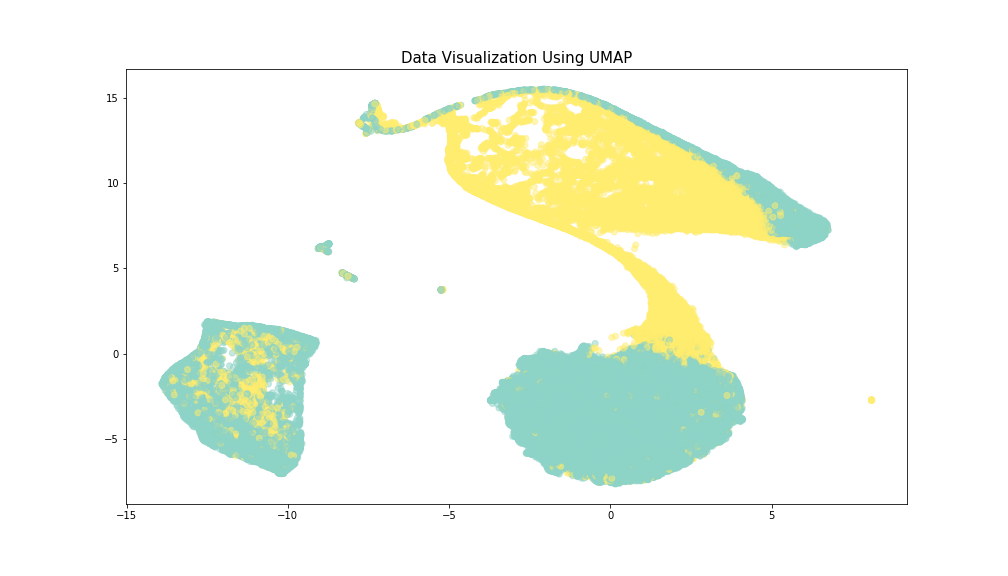

In [6]:
display(Image(filename='./RAIN_TSNE.png'))
display(Image(filename='./RAIN_UMAP.png'))

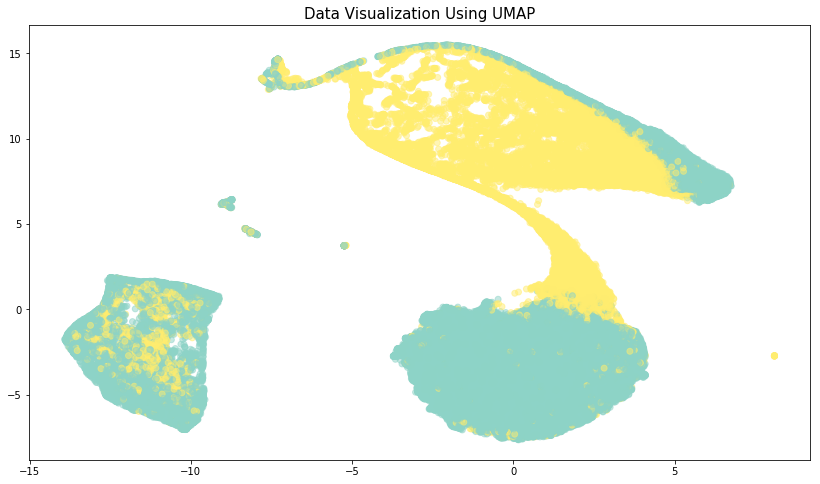

In [5]:
color = label.replace({"No" : 0 , "Yes" : 1})
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(Input.values)
plt.rcParams["figure.figsize"] = (14,8)
plt.scatter(embedding[:, 0], 
            embedding[:, 1],
            c= color, 
            cmap=plt.cm.get_cmap("Set3", 2), alpha=0.5)

plt.title("Data Visualization Using UMAP" , fontsize = 15)
plt.savefig("./RAIN_UMAP.png")
plt.show()

# Neural Network에 들어가는 HyperParameter
* `Hidden Layer 수`
    * 4 ~ 9 
* `초기 hidden node size `
    * Input size -10 ~ Input size + 20
* `Layer를 늘릴 수록 줄어나가는 Node 수`
    * 9 ~ 15
* `Learning rate `
    * 0.001 ~ 0.01
* `dropout rate`
    * [alpha dropout](https://arxiv.org/pdf/1706.02515.pdf)에서 drop rate의 정도 (0.01 ~ 0.3)
* `activation`
    * leaky_relu 
    * relu
    * elu
    * relu6
    * selu
* `focal weight` [focal loss](https://arxiv.org/abs/1708.02002#)
    * object detection에서 imbalance data 상황에서 사용하는 Loss에서 Parameter

# Bayesian Optimization

* 본래 목적 : 어떤 입력 $x$ 를 받는 미지의 목적 함수(Objective Function) $f$ 를 상정하여 그 것으 함수값 $f(x)$를 최대로 만드는 $x^*$를 찾는 것을 목적

* 이러한 함수값 $f(x)$를 계산하는 데 있어서 오랜시간이 소요되는 것을 가정하기 때문에, 이러한 상황에서 가능한 적은 수의 입력값 후보들에 대해서만 그 함구밧을 순차적으로 조사해 $f(x)$를 최대로 만드는 최적해 $x^*$를 빠르고 효과적으로 찾은 것이 주요 `목표`

* 두가지 필수 요소
    * `Surrogate Model` 
        * 현재까지 얻은 $(x_1,f(x_1) , ...,x_t,f(x_t))$를 바탕으로, 미지의 목적 함수의 형태에 대한 확률적인 추정을 수행하는 모델
        * 가장 많이 사용하는 확률 모델은 GP(Gaussian Process)
        * 현재까지 얻은 값을 통해 불확실성이 감소되는 방향으로 진행
    * `Acquisition Function`
        * 목적 함수에 대한 현재까지의 확률적 추정 결과를 바탕으로 `최적 입력값` $x^*$ 를 찾는데 있어 `유용할 만한 다음 후보` $x_{t+1}$를 추천해주는 함수.
        * exploitation , exploration
            * exploitation
                * 조사된 점에서 가장 큰 $f(x)$를 가진 점 근방에서 다음 점을 추천해주는 전략
            * exploration
                * 불확실성이 가장 큰 포인트에서 다음 점을 추천해주는 전략


# Algorithm

1. for t = 1,2,3.... do
2. 현재까지 얻은 $(x_1,f(x_1) , ...,x_t,f(x_t))$에 대한 Surrogate Model의 확률적 추정 결과를 바탕으로, Acquisition Function을 최대화하는 다음 입력값 후보 $x_{t+1}$을 선정
3. 새로 얻은 입력값 후보 $x_{t+1}$ 에 대한 함수값 $f(x_{t+1})$을 계산
4. 기존 모음에 $(x_{t+1} , f(x_{t+1})$을 추가하고 Surrogate Model의 확률적 추정 결과 다시 수행


# Acquisition Function ( EI , UCB , PI )

* EI(Expected Improvement)
    * exploration 과 exploitation 2개의 전략을 일정 수준 포함해서 설계된 것
    * 가장 많이 사용하는 Acquisition Function
    * $f(x_1) , f(x_2) , ,,, f(x_n) $ 중 최대 함수값 $f(x^{+}) = max_i f(x_i)$ 보다 큰 함수값을 도출학 확률(Probability Imporvement(PI)) 와  $f(x^{+})$간의 차이값을 종합적으로 고려하여 후보 변수의 유용성을 나타내는 숫자 출력
    * $f(x_{t+1}) - f(x^{+})$ + $f(x_{t+1}$ 에 대한 $\mu(f(x_{t+1})+\sigma(f(x_{t+1})$ 를 더해준 것이 `PI`이다.
    * $P(f(x_{t+1}) > \mu(f(x_{t+1})-\sigma(f(x_{t+1}))$ 을 통해서 가능성에 대한 확률값을 구한다.
    * $\xi$라는 hyperparamter를 통해 exploitation과 exploration을 고려할 수 있다.
        * $\xi$ 크게 할수록 exploration을 더 많이 고려하고 작게 할수록 exploitation을 더 많이 고려한다.

* 여기서 점이라고 하는 것은 Parameter를 나타낸다.

# Tensorflow 를 활용해 Architecture 구성

In [7]:
active_dict = {0: "leaky_relu" , 1 : "relu" , 2 : "elu", 3 : "relu6" , 4 : "selu"}

## Binsary classification일 때 사용하는 Focal Loss
def focal_loss_sigmoid(labels,logits,alpha=0.25 , gamma=2):
    y_pred=tf.nn.sigmoid(logits)
    labels=tf.to_float(labels)
    L=-labels*(1-alpha)*((1-y_pred)*gamma)*tf.log(  tf.maximum(y_pred , 1e-14 )   )-\
      (1-labels)*alpha*(y_pred**gamma)*tf.log( tf.maximum( 1-y_pred ,  1e-14 ) ) 
    return L

def neural_network(num_hidden, size_layer, learning_rate , dropout_rate,
                   activation , focal_weight , reduction_node , batch_size = 512 ,
                   x_train = x_train , y_train = y_train  ):
    
    tf.reset_default_graph()
    ## Static Graph 구성
    tf.random.set_random_seed(1234)
    X = tf.placeholder(tf.float32, (None, x_data.shape[1]))
    Y = tf.placeholder(tf.float32, (None, onehot.shape[1]))
    ## dropout 
    keep_prob = tf.placeholder(tf.float32)
    
    ## activation 과 alpha dropout 함수 구현
    def activate(activation, first_layer, second_layer, bias ):
        if activation == 0:
            activation = tf.nn.leaky_relu
        elif activation == 1:
            activation = tf.nn.relu
        elif activation == 2:
            activation = tf.nn.elu
        elif activation == 3:
            activation = tf.nn.relu6
        else :
            activation = tf.nn.selu
        layer = activation(tf.matmul(first_layer, second_layer) + bias)
        return tf.contrib.nn.alpha_dropout(layer, keep_prob)

    ## 초기 input과 Output Variable 생성
    input_layer = tf.Variable(tf.contrib.layers.xavier_initializer()((x_data.shape[1], size_layer)))
    biased_layer = tf.Variable(tf.random_normal([size_layer], stddev = 0.1))
    output_layer = tf.Variable(tf.contrib.layers.xavier_initializer()((size_layer - reduction_node * (num_hidden - 1), onehot.shape[1])))
    biased_output = tf.Variable(tf.random_normal([onehot.shape[1]], stddev = 0.1))
    
    ## 중간에 Variable loop를 통해서 생성
    layers, biased = [], []
    init_layer = size_layer
    layer_node_list = [size_layer]
    for i in range(num_hidden - 1):
        size_layer2 = size_layer - reduction_node 
        layers.append(tf.Variable(tf.contrib.layers.xavier_initializer()((size_layer, size_layer2))))        
        biased.append(tf.Variable(tf.random_normal([size_layer2])))
        layer_node_list.append(size_layer2)
        size_layer = size_layer2
    
    ## Network 구성
    first_l = activate(activation, X, input_layer, biased_layer)
    next_l = activate(activation, first_l, layers[0], biased[0])
    for i in range(1, num_hidden - 1):
        next_l = activate(activation, next_l, layers[i], biased[i])
    
    last_l = tf.matmul(next_l, output_layer) + biased_output
    ## Loss Function 구성
    cost  = tf.reduce_mean(\
                           focal_loss_sigmoid( \
                                              logits = last_l,
                                              labels = Y ,
                                              alpha = focal_weight ))
    ## Optimizer ADAM 사용
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    last_pred          = tf.nn.sigmoid(last_l)
    last_pred          = tf.argmax( last_pred , 1)
    last_y             = tf.argmax(Y, 1)
    correct_prediction = tf.equal(last_pred, last_y)
    ## Metirc : Accuracy
    accuracy           = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    ## Tensorflow Session 시행
    config=tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    sess.run(tf.global_variables_initializer())
    
    COST, TEST_COST, ACC, TEST_ACC = [], [], [], []
    reduce_node = min( int(reduction_node) , int(np.around(init_layer) / np.around(num_hidden) )- 3  )
    print("num hidden layer : {}, layer : {} , lr : {}, dropout rate : {},  activation : {}, Focal Weight : {}, Reduction Node : {}"\
          .format(int(np.around(num_hidden)), layer_node_list , learning_rate , dropout_rate  , active_dict.get(int(activation)) , focal_weight , reduce_node))
    ## Epoch : 3000 batch size 1024
    for i in range(50):
        train_acc, train_loss = 0, 0
        train_dt = np.concatenate((x_train , y_train) , axis = 1)
        np.random.shuffle(train_dt)
        x_train = train_dt[:,:-2]
        y_train = train_dt[:,-2:]
        for n in range(0, (x_train.shape[0] // batch_size) * batch_size, batch_size):
            _, loss ,  ACC2  =\
            sess.run([optimizer, cost , accuracy ], 
                     feed_dict = {X: x_train[n: n + batch_size, :],
                                  Y: y_train[n: n + batch_size, :],
                                  keep_prob : dropout_rate })
            
            train_acc  += ACC2
            train_loss += loss
            
        
        train_loss /= (x_train.shape[0] // batch_size)
        train_acc /= (x_train.shape[0] // batch_size)
        ACC.append(train_acc)
        COST.append(train_loss)
    
    TEST_COST.append(sess.run(cost, feed_dict = {X: x_valid, Y: y_valid , keep_prob : 1.0}))
    TEST_ACC.append(sess.run([accuracy], feed_dict = {X: x_valid, Y: y_valid , keep_prob : 1.0}))
    COST = np.array(COST).mean()
    ACC = np.array(ACC).mean()
    TEST_COST = np.array(TEST_COST).mean()
    TEST_ACC = np.array(TEST_ACC).mean()
    return COST, TEST_COST, ACC, TEST_ACC

## Generate NN 

* Parameter 범위에서 오류가 날 경우를 고려하여 최소한의 제한을 줘서 오류를 방지

In [8]:
def generate_nn(num_hidden, size_layer, learning_rate, dropout_rate, activation , focal_weight , reduction_node):
    global accbest
    global Bayes_iter
    param = {
        'num_hidden'     : int(np.around(num_hidden)),
        'size_layer'     : int(np.around(size_layer)),
        'learning_rate'  : max(min(learning_rate, 0.05), 0.001),
        'dropout_rate'   : max(min(dropout_rate, 0.3), 0.05),
        'activation'     : int(np.around(activation)) , 
        "focal_weight"   : max( min(focal_weight , 0.5) , 0.01) ,
        "reduction_node" : min( int(reduction_node) , int(np.around(size_layer) / np.around(num_hidden) )- 2 ) ,
    }
    ## 선택된 Parameter Print 하고 저장
    print("\n Search parameters \n %s" % (param), file = log_file)
    log_file.flush()
    train_cost, valid_cost, train_acc, valid_acc  = neural_network(**param)
    f = open("Report_bayesian_result.txt",'a')
    ## Baye iteration 마다 결과값 Print
    result_ =\
    "BayesIter : {} Train cost {:.3f}, Valid cost {:.3f}, Train acc {:.3f}, Valid acc {:.3f} \n".\
    format(Bayes_iter , train_cost, valid_cost, train_acc, valid_acc)
    print(result_)
    Bayes_iter +=1
    f.write(result_)
    if (valid_acc > accbest):
        accbest = valid_acc
    print(accbest)
    return valid_acc

# Maximize 함수

## maximize( init_points = `n` , n_iter = `N-n` ,  acq = `ei` ,  xi = 0.1 )

## init_points 

* 범위 내에서 랜덤하게 샘플링해서 $(x_1, f(x_1), x_2, f(x_2) ,... , x_n, f(x_n))$ 모은 다음 `Surrogate Model`로 확률적 추정 수행

## n_iter
* 그 다음 $t = n+1 , n+2 , ... N $ 에 대하여 다음과 같은 과정을 반복적으로 수행합니다.
* $(x_1, f(x_1), x_2, f(x_2) ,... , x_n, f(x_n))$ 에 대하여 `Surrogate Model`로 확률적 추정 결과를 바탕으로  `Acquisition Function` 을 이용해 목적함수를 최대로 하는 $x^*$ 를 찾는 데 쓸만한 $x_{t+1}$을 추천해줍니다.($x_{t+1}$ = Paramters)
* $x_{t+1}$값을 이용해 계산하여 성능 수치를 얻은 것을 $f(x)$값으로 얻습니다.
* 그 다음 기존 입력값 모음에 $(x_{t+1} , f(x_{t+1}))$를 추가하고 다시 `Surrogate Model`로 확률적 추정 결과를 바탕으로  `Acquisition Function` 을 이용해 목적함수를 최대로 하는 $x^*$ 를 찾는 데 쓸만한 $x_{t+2}$을 추천해줍니다.
* 이렇게 총 `N`개를 바탕으로 입력값-함수값 점들에 대하여 확률적으로 추정된 목적 함수 결과물을 바탕으로, 평균 함수 $\mu(x)$를 최대로 하는 최적해 $x^{*}$를 최종 선택합니다. 
* 이렇게 얻은 $x^{*}$ 값인 Paramter로 딥러닝 모델을 학습하면, 일반화 성능이 극대화된 모델을 기대할 수 있습니다.
        
## acq     

* Acquisition Function (ucb , ei , poi)
    * `ucb` / kappa
    * `ei`  / xi
    * `poi` / xi

## Default Gaussian Process
* kernel matern(nu=2.5)
* alpha = 1e-6
* normalize_y = True
* n_restarts_optimizer=25

In [9]:
log_file = open('Report_Bayesian_param.log', 'a')
accbest = 0.5
Bayes_iter = 1
first_layer = np.shape(x_data)[1]
NN_BAYESIAN = BayesianOptimization(generate_nn, 
                              {'num_hidden': (4, 9),
                               'size_layer': ( first_layer -5 ,first_layer + 20 ),
                               'learning_rate': (0.05, 0.001),
                               'dropout_rate': (0.1, 0.3),
                               'activation': (0, 4),
                               "focal_weight" : (0.1 , 0.3),
                               "reduction_node" : (10 , 15 ) 
                              })

NN_BAYESIAN.maximize(init_points = 20 , n_iter = 200 , acq="ei", xi=0.1 )

|   iter    |  target   | activa... | dropou... | focal_... | learni... | num_hi... | reduct... | size_l... |
-------------------------------------------------------------------------------------------------------------

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
num hidden layer : 8, layer : [76, 69, 62, 55, 48, 41, 34, 27] , lr : 0.003586646989563451, dropout rate : 0.171747507554793,  activation : selu, Focal Weight : 0.18825773561199777, Reduction Node : 6
BayesIter : 1 Train cost 0.048, Valid cost 0.053, Train acc 0.932, Valid acc 0.988 

0.98809135
|  1        |  0.9881   |  3.649    |  0.1717   |  0.1883   |  0.003587 |  8.188    |  12.27    |  75.66    |
num hidden layer 

BayesIter : 16 Train cost 0.106, Valid cost 0.103, Train acc 0.773, Valid acc 0.775 

0.99458486
|  16       |  0.7755   |  1.093    |  0.1361   |  0.1836   |  0.04899  |  5.529    |  13.02    |  69.77    |
num hidden layer : 7, layer : [74, 66, 58, 50, 42, 34, 26] , lr : 0.043525594896278275, dropout rate : 0.1481112464859526,  activation : elu, Focal Weight : 0.2278500443661359, Reduction Node : 7
BayesIter : 17 Train cost 0.173, Valid cost 2.986, Train acc 0.768, Valid acc 0.820 

0.99458486
|  17       |  0.8195   |  2.351    |  0.1481   |  0.2279   |  0.04353  |  7.009    |  13.34    |  74.01    |
num hidden layer : 6, layer : [65, 57, 49, 41, 33, 25] , lr : 0.031016982730912964, dropout rate : 0.10944405536983104,  activation : relu6, Focal Weight : 0.1195752075289883, Reduction Node : 7
BayesIter : 18 Train cost 0.082, Valid cost 0.081, Train acc 0.775, Valid acc 0.775 

0.99458486
|  18       |  0.7755   |  2.735    |  0.1094   |  0.1196   |  0.03102  |  6.359    |  14.1     | 

BayesIter : 34 Train cost 0.535, Valid cost 22.366, Train acc 0.775, Valid acc 0.279 

0.9971869
|  34       |  0.2795   |  3.914    |  0.1628   |  0.1379   |  0.05     |  4.167    |  14.31    |  62.21    |
num hidden layer : 8, layer : [62, 57, 52, 47, 42, 37, 32, 27] , lr : 0.05, dropout rate : 0.17392196530492698,  activation : leaky_relu, Focal Weight : 0.15560772356063285, Reduction Node : 4
BayesIter : 35 Train cost 8.535, Valid cost 6.674, Train acc 0.712, Valid acc 0.775 

0.9971869
|  35       |  0.7755   |  0.02389  |  0.1739   |  0.1556   |  0.05     |  7.841    |  14.9     |  62.19    |
num hidden layer : 4, layer : [66, 56, 46, 36] , lr : 0.05, dropout rate : 0.12244857745671643,  activation : selu, Focal Weight : 0.1743276953861284, Reduction Node : 10
BayesIter : 36 Train cost 0.415, Valid cost 13.036, Train acc 0.774, Valid acc 0.279 

0.9971869
|  36       |  0.2793   |  3.838    |  0.1224   |  0.1743   |  0.05     |  4.001    |  10.12    |  65.66    |
num hidden layer

BayesIter : 52 Train cost 6.670, Valid cost 6.565, Train acc 0.740, Valid acc 0.775 

0.9971869
|  52       |  0.7755   |  3.971    |  0.2881   |  0.1858   |  0.05     |  8.856    |  14.95    |  68.57    |
num hidden layer : 8, layer : [84, 76, 68, 60, 52, 44, 36, 28] , lr : 0.05, dropout rate : 0.2894733027730496,  activation : selu, Focal Weight : 0.2944434714316492, Reduction Node : 7
BayesIter : 53 Train cost 4.657, Valid cost 6.172, Train acc 0.771, Valid acc 0.775 

0.9971869
|  53       |  0.7755   |  3.998    |  0.2895   |  0.2944   |  0.05     |  8.253    |  12.61    |  83.78    |
num hidden layer : 4, layer : [86, 76, 66, 56] , lr : 0.05, dropout rate : 0.25025802236955513,  activation : selu, Focal Weight : 0.2394031354738733, Reduction Node : 10
BayesIter : 54 Train cost 1.419, Valid cost 5.266, Train acc 0.869, Valid acc 0.814 

0.9971869
|  54       |  0.8144   |  3.836    |  0.2503   |  0.2394   |  0.05     |  4.091    |  10.05    |  86.09    |
num hidden layer : 7, laye

BayesIter : 70 Train cost 10.383, Valid cost 6.341, Train acc 0.698, Valid acc 0.775 

0.9971869
|  70       |  0.7755   |  0.04243  |  0.1408   |  0.2477   |  0.05     |  8.41     |  10.05    |  80.04    |
num hidden layer : 4, layer : [65, 52, 39, 26] , lr : 0.05, dropout rate : 0.2350765256160572,  activation : leaky_relu, Focal Weight : 0.25351661048486585, Reduction Node : 13
BayesIter : 71 Train cost 1.443, Valid cost 0.649, Train acc 0.947, Valid acc 0.978 

0.9971869
|  71       |  0.9783   |  0.08743  |  0.2351   |  0.2535   |  0.05     |  4.058    |  13.41    |  64.61    |
num hidden layer : 6, layer : [64, 56, 48, 40, 32, 24] , lr : 0.05, dropout rate : 0.17240977157795773,  activation : leaky_relu, Focal Weight : 0.17353854462575694, Reduction Node : 7
BayesIter : 72 Train cost 6.887, Valid cost 6.609, Train acc 0.741, Valid acc 0.775 

0.9971869
|  72       |  0.7755   |  0.03775  |  0.1724   |  0.1735   |  0.05     |  5.632    |  13.36    |  63.9     |
num hidden layer : 

BayesIter : 88 Train cost 1.406, Valid cost 3.701, Train acc 0.871, Valid acc 0.860 

0.9971869
|  88       |  0.8604   |  3.73     |  0.2397   |  0.2883   |  0.05     |  4.011    |  14.99    |  73.08    |
num hidden layer : 5, layer : [87, 77, 67, 57, 47] , lr : 0.05, dropout rate : 0.1233031716773668,  activation : elu, Focal Weight : 0.1808013366659185, Reduction Node : 10
BayesIter : 89 Train cost 0.740, Valid cost 9.835, Train acc 0.715, Valid acc 0.285 

0.9971869
|  89       |  0.2851   |  2.105    |  0.1233   |  0.1808   |  0.05     |  5.377    |  10.88    |  86.94    |
num hidden layer : 4, layer : [85, 75, 65, 55] , lr : 0.05, dropout rate : 0.21193059483584362,  activation : leaky_relu, Focal Weight : 0.1775395985938366, Reduction Node : 10
BayesIter : 90 Train cost 2.014, Valid cost 0.789, Train acc 0.927, Valid acc 0.973 

0.9971869
|  90       |  0.9731   |  0.01481  |  0.2119   |  0.1775   |  0.05     |  4.026    |  10.12    |  84.9     |
num hidden layer : 4, layer : [8

BayesIter : 106 Train cost 0.277, Valid cost 0.425, Train acc 0.840, Valid acc 0.936 

0.9971869
|  106      |  0.9358   |  1.727    |  0.2997   |  0.141    |  0.05     |  4.025    |  13.64    |  72.15    |
num hidden layer : 4, layer : [87, 73, 59, 45] , lr : 0.05, dropout rate : 0.21023726831103823,  activation : elu, Focal Weight : 0.22365834651714822, Reduction Node : 14
BayesIter : 107 Train cost 1.554, Valid cost 8.126, Train acc 0.815, Valid acc 0.782 

0.9971869
|  107      |  0.7815   |  1.816    |  0.2102   |  0.2237   |  0.05     |  4.159    |  14.99    |  86.99    |
num hidden layer : 6, layer : [80, 69, 58, 47, 36, 25] , lr : 0.05, dropout rate : 0.16993997542083528,  activation : leaky_relu, Focal Weight : 0.16860118176692593, Reduction Node : 10
BayesIter : 108 Train cost 5.090, Valid cost 6.627, Train acc 0.758, Valid acc 0.775 

0.9971869
|  108      |  0.7755   |  0.02347  |  0.1699   |  0.1686   |  0.05     |  6.209    |  14.85    |  80.0     |
num hidden layer : 4, 

BayesIter : 124 Train cost 12.285, Valid cost 27.742, Train acc 0.715, Valid acc 0.775 

0.9971869
|  124      |  0.7755   |  0.08894  |  0.1843   |  0.1394   |  0.05     |  8.862    |  14.94    |  72.51    |
num hidden layer : 9, layer : [68, 63, 58, 53, 48, 43, 38, 33, 28] , lr : 0.05, dropout rate : 0.20141989176919814,  activation : elu, Focal Weight : 0.2568152666470064, Reduction Node : 4
BayesIter : 125 Train cost 0.205, Valid cost 1.935, Train acc 0.764, Valid acc 0.225 

0.9971869
|  125      |  0.2245   |  2.054    |  0.2014   |  0.2568   |  0.05     |  8.998    |  13.83    |  68.37    |
num hidden layer : 7, layer : [69, 62, 55, 48, 41, 34, 27] , lr : 0.05, dropout rate : 0.29295513214261565,  activation : leaky_relu, Focal Weight : 0.10771130391896425, Reduction Node : 6
BayesIter : 126 Train cost 6.184, Valid cost 6.847, Train acc 0.759, Valid acc 0.775 

0.9971869
|  126      |  0.7755   |  0.02977  |  0.293    |  0.1077   |  0.05     |  6.89     |  14.98    |  69.06    |

BayesIter : 142 Train cost 1.627, Valid cost 0.789, Train acc 0.942, Valid acc 0.972 

0.9971869
|  142      |  0.9724   |  0.0719   |  0.2798   |  0.1405   |  0.05     |  4.107    |  14.95    |  78.1     |
num hidden layer : 4, layer : [75, 65, 55, 45] , lr : 0.05, dropout rate : 0.1979336880187746,  activation : leaky_relu, Focal Weight : 0.2696652497796213, Reduction Node : 10
BayesIter : 143 Train cost 1.706, Valid cost 0.745, Train acc 0.937, Valid acc 0.973 

0.9971869
|  143      |  0.9734   |  0.07938  |  0.1979   |  0.2697   |  0.05     |  4.063    |  10.66    |  75.48    |
num hidden layer : 4, layer : [68, 58, 48, 38] , lr : 0.05, dropout rate : 0.2504098073935199,  activation : leaky_relu, Focal Weight : 0.28866923763614516, Reduction Node : 10
BayesIter : 144 Train cost 1.460, Valid cost 0.955, Train acc 0.945, Valid acc 0.965 

0.9971869
|  144      |  0.9654   |  0.1053   |  0.2504   |  0.2887   |  0.05     |  4.054    |  10.33    |  67.97    |
num hidden layer : 9, laye

BayesIter : 160 Train cost 0.695, Valid cost 2.709, Train acc 0.865, Valid acc 0.880 

0.9971869
|  160      |  0.8804   |  1.793    |  0.2452   |  0.1518   |  0.05     |  4.033    |  12.66    |  64.15    |
num hidden layer : 9, layer : [62, 58, 54, 50, 46, 42, 38, 34, 30] , lr : 0.05, dropout rate : 0.16428895591192777,  activation : leaky_relu, Focal Weight : 0.2703936810444275, Reduction Node : 3
BayesIter : 161 Train cost 10.911, Valid cost 23.520, Train acc 0.692, Valid acc 0.775 

0.9971869
|  161      |  0.7755   |  0.09492  |  0.1643   |  0.2704   |  0.05     |  8.68     |  12.91    |  62.06    |
num hidden layer : 4, layer : [62, 52, 42, 32] , lr : 0.05, dropout rate : 0.24876692817341486,  activation : relu6, Focal Weight : 0.20780948658653714, Reduction Node : 10
BayesIter : 162 Train cost 0.074, Valid cost 0.045, Train acc 0.852, Valid acc 0.984 

0.9971869
|  162      |  0.9838   |  3.376    |  0.2488   |  0.2078   |  0.05     |  4.061    |  10.01    |  62.21    |
num hidd

BayesIter : 178 Train cost 0.202, Valid cost 1.102, Train acc 0.763, Valid acc 0.225 

0.9971869
|  178      |  0.2245   |  2.444    |  0.1656   |  0.2853   |  0.05     |  6.538    |  10.01    |  80.29    |
num hidden layer : 9, layer : [78, 72, 66, 60, 54, 48, 42, 36, 30] , lr : 0.05, dropout rate : 0.20612539018653508,  activation : leaky_relu, Focal Weight : 0.1563942800453055, Reduction Node : 5
BayesIter : 179 Train cost 10.397, Valid cost 27.195, Train acc 0.718, Valid acc 0.775 

0.9971869
|  179      |  0.7755   |  0.001177 |  0.2061   |  0.1564   |  0.05     |  8.826    |  12.33    |  78.5     |
num hidden layer : 4, layer : [75, 63, 51, 39] , lr : 0.05, dropout rate : 0.2995061291975365,  activation : relu6, Focal Weight : 0.27534515537571225, Reduction Node : 12
BayesIter : 180 Train cost 0.070, Valid cost 0.050, Train acc 0.906, Valid acc 0.980 

0.9971869
|  180      |  0.9798   |  3.312    |  0.2995   |  0.2753   |  0.05     |  4.007    |  12.38    |  75.27    |
num hidde

BayesIter : 196 Train cost 0.103, Valid cost 2.061, Train acc 0.765, Valid acc 0.225 

0.9971869
|  196      |  0.2245   |  2.188    |  0.288    |  0.121    |  0.05     |  5.751    |  10.06    |  63.77    |
num hidden layer : 7, layer : [66, 59, 52, 45, 38, 31, 24] , lr : 0.05, dropout rate : 0.2870389175845851,  activation : selu, Focal Weight : 0.18751285314095756, Reduction Node : 6
BayesIter : 197 Train cost 3.236, Valid cost 6.559, Train acc 0.774, Valid acc 0.775 

0.9971869
|  197      |  0.7755   |  3.976    |  0.287    |  0.1875   |  0.05     |  7.408    |  13.04    |  66.22    |
num hidden layer : 4, layer : [63, 50, 37, 24] , lr : 0.05, dropout rate : 0.17400165953750177,  activation : relu, Focal Weight : 0.2229027335243589, Reduction Node : 12
BayesIter : 198 Train cost 0.117, Valid cost 0.113, Train acc 0.774, Valid acc 0.775 

0.9971869
|  198      |  0.7755   |  0.9738   |  0.174    |  0.2229   |  0.05     |  4.035    |  14.0     |  63.09    |
num hidden layer : 4, laye

num hidden layer : 4, layer : [63, 51, 39, 27] , lr : 0.05, dropout rate : 0.23896614340418013,  activation : relu6, Focal Weight : 0.17237566058934164, Reduction Node : 12
BayesIter : 215 Train cost 0.072, Valid cost 0.078, Train acc 0.843, Valid acc 0.983 

0.9971869
|  215      |  0.9829   |  3.281    |  0.239    |  0.1724   |  0.05     |  4.032    |  12.01    |  62.83    |
num hidden layer : 5, layer : [62, 52, 42, 32, 22] , lr : 0.05, dropout rate : 0.2145598465725972,  activation : elu, Focal Weight : 0.2521048502389073, Reduction Node : 9
BayesIter : 216 Train cost 0.698, Valid cost 2.830, Train acc 0.806, Valid acc 0.821 

0.9971869
|  216      |  0.8211   |  2.266    |  0.2146   |  0.2521   |  0.05     |  5.329    |  10.12    |  62.09    |
num hidden layer : 9, layer : [82, 75, 68, 61, 54, 47, 40, 33, 26] , lr : 0.05, dropout rate : 0.1409137717308352,  activation : selu, Focal Weight : 0.24924232320558318, Reduction Node : 6
BayesIter : 217 Train cost 6.483, Valid cost 24.202

# Experiment

In [58]:
Report1 = pd.read_csv("./Report1.csv")
Report2 = pd.read_csv("./Report2.csv")
Report3 = pd.read_csv("./Report3.csv")
Report4 = pd.read_csv("./Report4.csv")
col = Report2.columns.tolist()

In [59]:
def vis(report) :
    f, ax = plt.subplots( 1,  2, figsize=(20, 5))
    ax1 = ax.flatten()[0]
    ax1.plot(report["Iter"],report["Train Cost"] )
    ax1.plot(report["Iter"],report["Test Cost"] )
    ax1.set_title("Loss Graph" , fontsize = 30)
    ax1.set_xlabel('Bayesian Iteration', fontsize = 20)
    ax1.set_ylabel('Loss', fontsize = 20)
    ax1.legend()
    ax2 = ax.flatten()[1]
    ax2.plot(report["Iter"],report["Train ACC"] )
    ax2.plot(report["Iter"],report["Test ACC"] )
    ax2.set_title("ACC Graph" , fontsize = 30)
    ax2.legend()
    ax2.set_xlabel('Bayesian Iteration' , fontsize = 20)
    ax2.set_ylabel('Accuracy', fontsize = 20)
    plt.show()

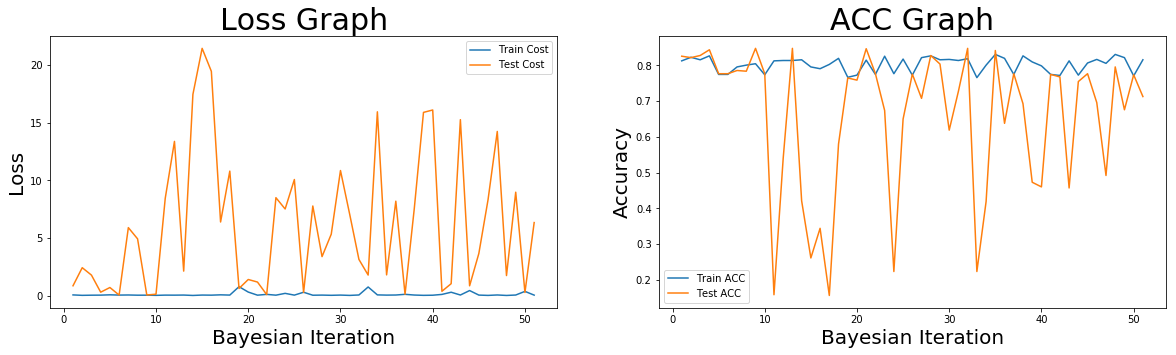

,Iter,Train Cost,Test Cost,Train ACC,Test ACC,num_hidden,size layer,learning rate,dropout rate,activation,focal weight,reduce node
0,1,0.104,0.894,0.813,0.826,5.0,72.0,0.004828,0.200000,selu,0.173102,11.0
1,2,0.067,2.458,0.823,0.822,9.0,85.0,0.005277,0.292889,elu,0.205950,6.0
2,3,0.080,1.816,0.816,0.828,6.0,60.0,0.008621,0.229970,relu,0.281366,7.0
3,4,0.085,0.339,0.827,0.844,8.0,74.0,0.007973,0.200000,relu6,0.146833,6.0
4,5,0.112,0.744,0.775,0.777,9.0,67.0,0.003491,0.200000,elu,0.242006,4.0
5,6,0.089,0.091,0.775,0.777,6.0,59.0,0.003751,0.200000,elu,0.165771,6.0
6,7,0.098,5.922,0.796,0.786,6.0,76.0,0.009741,0.241602,relu,0.153666,9.0
7,8,0.080,4.952,0.801,0.784,5.0,67.0,0.005849,0.215532,relu6,0.104460,10.0
8,9,0.082,0.099,0.805,0.848,4.0,86.0,0.010000,0.200000,selu,0.167846,14.0
9,10,0.066,0.166,0.774,0.777,9.0,76.0,0.010000,0.257670,leaky_relu,0.193433,5.0


In [60]:
vis(Report1)
Report1[col]

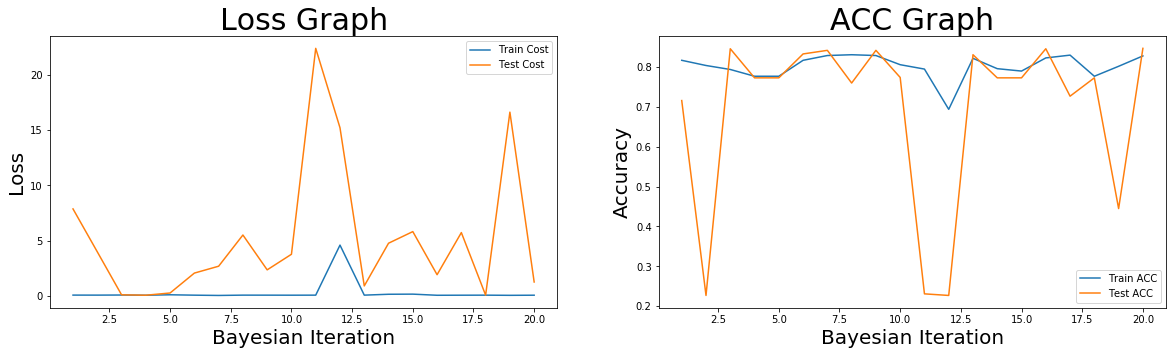

,Iter,Train Cost,Test Cost,Train ACC,Test ACC,num_hidden,size layer,learning rate,dropout rate,activation,focal weight,reduce node
0,1,0.094,7.881,0.817,0.716,8.0,67.0,0.007891,0.200000,elu,0.199944,5.0
1,2,0.092,4.005,0.804,0.227,7.0,78.0,0.007168,0.200000,relu,0.215253,8.0
2,3,0.101,0.120,0.794,0.846,9.0,70.0,0.009638,0.227055,relu6,0.123706,4.0
3,4,0.082,0.083,0.777,0.773,7.0,78.0,0.005170,0.200000,selu,0.166876,8.0
4,5,0.123,0.285,0.777,0.773,4.0,57.0,0.007292,0.200000,elu,0.218044,9.0
5,6,0.088,2.083,0.817,0.833,9.0,71.0,0.002371,0.256296,elu,0.123427,4.0
6,7,0.063,2.704,0.829,0.842,4.0,76.0,0.008634,0.219430,leaky_relu,0.275879,9.0
7,8,0.091,5.523,0.831,0.760,6.0,64.0,0.004234,0.260028,elu,0.243544,7.0
8,9,0.089,2.375,0.829,0.842,5.0,57.0,0.004563,0.200000,elu,0.194805,8.0
9,10,0.086,3.783,0.806,0.774,9.0,86.0,0.010000,0.200000,leaky_relu,0.192798,6.0


In [62]:
vis(Report2)

Report2[col]

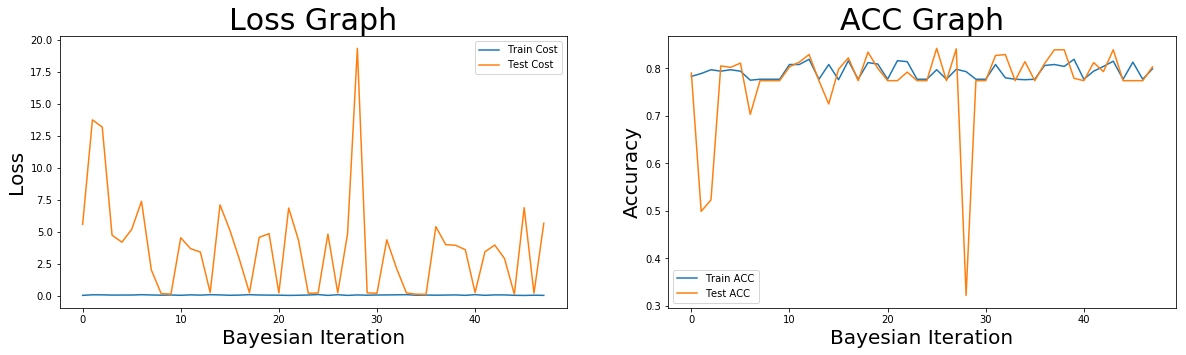

,Iter,Train Cost,Test Cost,Train ACC,Test ACC,num_hidden,size layer,learning rate,dropout rate,activation,focal weight,reduce node
0,0,0.066,5.602,0.783,0.790,6.0,63.0,0.001,0.2,elu,0.104016,7.0
1,1,0.111,13.739,0.789,0.499,6.0,80.0,0.001,0.2,elu,0.202795,10.0
2,2,0.107,13.174,0.797,0.523,8.0,68.0,0.001,0.2,leaky_relu,0.296618,5.0
3,3,0.087,4.756,0.794,0.805,7.0,62.0,0.001,0.2,leaky_relu,0.283971,5.0
4,4,0.092,4.208,0.797,0.802,5.0,79.0,0.001,0.2,elu,0.179080,12.0
5,5,0.091,5.211,0.794,0.811,4.0,65.0,0.001,0.2,elu,0.202757,13.0
6,6,0.119,7.398,0.775,0.703,8.0,86.0,0.001,0.2,elu,0.198358,7.0
7,7,0.097,2.052,0.777,0.774,8.0,58.0,0.001,0.2,elu,0.293632,4.0
8,8,0.080,0.210,0.777,0.774,9.0,80.0,0.001,0.2,relu,0.194492,5.0
9,9,0.096,0.163,0.777,0.774,9.0,67.0,0.001,0.2,selu,0.119088,4.0


In [63]:
vis(Report3)
Report3[col]

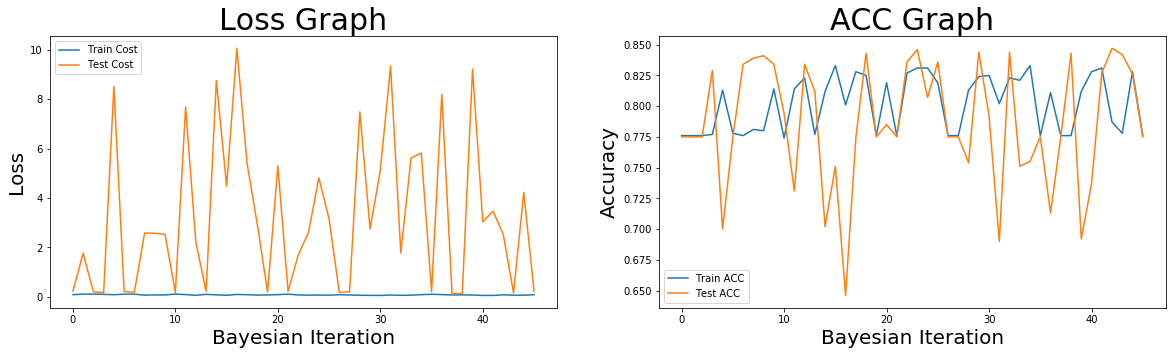

,Iter,Train Cost,Test Cost,Train ACC,Test ACC,num_hidden,size layer,learning rate,dropout rate,activation,focal weight,reduce node
0,0,0.089,0.226,0.776,0.775,9.0,71.0,0.001,0.2,selu,0.140489,4.0
1,1,0.107,1.761,0.776,0.775,7.0,68.0,0.001,0.2,relu,0.281986,6.0
2,2,0.112,0.205,0.776,0.775,5.0,59.0,0.001,0.2,relu6,0.294239,8.0
3,3,0.098,0.163,0.777,0.829,8.0,63.0,0.001,0.2,relu6,0.195324,4.0
4,4,0.085,8.507,0.813,0.700,6.0,62.0,0.001,0.2,leaky_relu,0.203449,7.0
5,5,0.106,0.210,0.778,0.775,8.0,79.0,0.001,0.2,relu6,0.231195,6.0
6,6,0.108,0.191,0.776,0.834,6.0,80.0,0.001,0.2,relu6,0.267976,10.0
7,7,0.067,2.584,0.781,0.839,7.0,67.0,0.001,0.2,relu,0.111885,6.0
8,8,0.074,2.571,0.780,0.841,8.0,58.0,0.001,0.2,relu,0.128103,4.0
9,9,0.075,2.518,0.814,0.834,4.0,61.0,0.001,0.2,elu,0.158542,12.0


In [64]:
vis(Report4)
Report4[col]

# Conclusion

* BayesianOptimization을 통해서 Neural Network 구조에서 사람들이 경험적으로 선택하는 부분에 대해서 최적의 Parameter를 찾아보고자 했다.
* 위의 테스트를 살펴보니 주로 activation에서는 끝으로 갈수록 `selu`가 많이 나오는 것 같다.
* 이론상으로는 Bayesian iteration이 늘어날수록 점점 좋아지는 결과를 기대했는데, 실제로 그러지 못한 것을 확인했다.
    * 아무래도 parameter space가 크다보니, 조금 움직였을 때 더 안좋은 결과로 빠져버리는 것 같다.
* 실제로 돌아가는 시간이 iteration 마다 epoch을 3000번 돌리는 식으로 하니 시간이 많이 소요된다.
* 한정된 시간 내에 Bayesian Iteration을 많이 하려면  Epoch을 줄여야해서, 그만큼 성능 개선이 안된 것 같다. 
* 그래서 Bayesian iteraion을 많이 늘렸지만, 성능이 잘 나오지는 않았다.
    * 그래서 더 알아보니 [gpflow](https://github.com/GPflow/GPflow)라는 병렬로하는 패키지가 있다고 한다.
    * 추후에는 패키지를 설치해서 다시 한번 적용해보려고 한다.
* 기존의 Random search 나 Grid search 보다 이론상으로는 좋은 hyperparameter search 이지만, Parameter space가 커질수록 더 많이 헤맬수도 있을 것 같다.